# **0. Intro**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
nb_path = "/content/drive/My Drive/NeuralODE"
if nb_path not in sys.path:
  sys.path.insert(5, nb_path)

!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y --prefix /usr/local jupyter
!python -m ipykernel install --name "py38" --user

!pip install git+https://github.com/DiffEqML/torchdyn.git

sys.path.append('/usr/local/lib/python3.8/site-packages/')

Mounted at /content/drive


# **1. Libraries**

In [ ]:
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *
import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
# quick run for automated notebook validation
dry_run = False

# **2. Dataset**

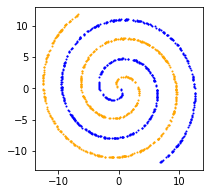

In [ ]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-1, dataset_type='spirals')

colors = ['orange', 'blue']
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])

# **3. Transform Dataset**

In [ ]:
temp = X.cpu().detach().numpy()
# temp = X.numpy()
b = np.append(temp,np.zeros([len(temp),1], dtype='f'),1)
X = torch.from_numpy(b) 

# **4. Training**

In [ ]:
import torch
import torch.utils.data as data
device = torch.device("cpu") # all of this works in GPU as well :)

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [ ]:
t_span = torch.linspace(0,1,50)

f = nn.Sequential(
        nn.Linear(3, 16),
        nn.Tanh(),
        nn.Linear(16, 128),
        nn.Tanh(),
        nn.Linear(128, 16),
        nn.Tanh(),
        nn.Linear(16, 3)
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)

learn = Learner(t_span, model)
if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=200, max_epochs=1000)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/usr/local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."
Missing logger folder: /content/lightning_logs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 4.4 K 
------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
/usr/local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging 

Training: 0it [00:00, ?it/s]

# **5. Plot**

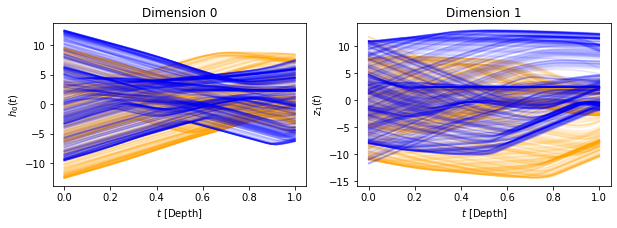

In [ ]:
t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cpu()
color=['orange', 'blue']

fig = plt.figure(figsize=(10,3))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for i in range(len(X)):
    ax0.plot(t_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(t_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")
ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1");

In [ ]:
# Evaluate vector field
n_pts = 10
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
XX, YY = torch.meshgrid(x, y)
z = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], 1)
t_eval_f, trajectory_f = model(z, t_span)

derivative = trajectory_f
dt = t_eval[1] - t_eval[0]
for i in range(len(t_eval)-1):
    derivative[i] = (trajectory_f[i+1, :, :] - trajectory_f[i, :, :]) / dt

derivative = derivative.detach().numpy()
z = z.detach().numpy()

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

try:
  os.mkdir(os.path.join(nb_path, "spiral3D"))
except Exception as e:
  print("Folder already exists")

plt.ioff()
colors = ['orange', 'blue']
for j in range(len(t_span)):
  fig = plt.figure(figsize = (10, 7))
  ax = plt.axes(projection ="3d")
  for i in range(len(X)):
    ax.scatter3D(trajectory[j,i,0], trajectory[j,i,1], trajectory[j,i,2], s=30, color=colors[yn[i].int()])
  fig.savefig(os.path.join(nb_path, "spiral3D", "spiral3D" + str(j)) , dpi=150)
  plt.close(fig)